In [ ]:
!unzip "/content/drive/MyDrive/deepfake.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [ ]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 16.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from keras.applications import ResNet50
import os
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, f1_score, accuracy_score
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Reshape, concatenate, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import mediapipe as mp

# Paths
train_path = "/content/Dataset/Train"
test_path = "/content/Dataset/Test"
val_path = "/content/Dataset/Validation"


In [ ]:
# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
training_set = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=64, class_mode='binary')
test_set = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)
val_set = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, class_mode='binary')


Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [ ]:
# Function to extract landmarks using MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

def extract_landmarks(image, target_resolution=(112, 112)):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, target_resolution)  # Downscale image
    result = face_mesh.process(image_rgb)
    if result.multi_face_landmarks:
        for face_landmarks in result.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                landmarks.append([lm.x, lm.y, lm.z])
            return np.array(landmarks).flatten()
    return np.zeros(468*3)  # Return zeros if no landmarks are found

# Prepare the data including landmarks
def prepare_data_with_landmarks(data_generator, target_resolution=(112, 112)):
    images = []
    labels = []
    landmarks = []
    for _ in range(len(data_generator)):
        img_batch, label_batch = next(data_generator)
        for img, label in zip(img_batch, label_batch):
            img = (img * 255).astype(np.uint8)  # Rescale back to [0, 255] for OpenCV
            img = cv2.resize(img, target_resolution)  # Downscale image
            landmark = extract_landmarks(img, target_resolution)
            images.append(img)
            labels.append(label)
            landmarks.append(landmark)
    return np.array(images), np.array(labels), np.array(landmarks)


train_images, train_labels, train_landmarks = prepare_data_with_landmarks(training_set)
val_images, val_labels, val_landmarks = prepare_data_with_landmarks(val_set)
test_images, test_labels, test_landmarks = prepare_data_with_landmarks(test_set)

# Normalize landmark data
train_landmarks = train_landmarks / np.max(train_landmarks)
val_landmarks = val_landmarks / np.max(val_landmarks)
test_landmarks = test_landmarks / np.max(test_landmarks)


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
cnn_output = Dense(128, activation='relu')(x)

# Define the landmark input
landmark_input = Input(shape=(468*3,))
landmark_dense = Dense(128, activation='relu')(landmark_input)

# Concatenate CNN and landmark outputs
combined = concatenate([cnn_output, landmark_dense])

# Final layers
combined = Dense(64, activation='relu')(combined)
predictions = Dense(1, activation='sigmoid')(combined)

# Create the model
combined_model = Model(inputs=[base_model.input, landmark_input], outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with periodic validation
epochs = 150
validate_every_n_epochs = 5
batch_size = 64

train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model
    history = combined_model.fit(
        [train_images, train_landmarks], train_labels,
        epochs=1,  # Train for one epoch at a time
        batch_size=batch_size,
        verbose=1
    )

    # Collect training metrics
    train_acc_history.append(history.history['accuracy'][0])
    train_loss_history.append(history.history['loss'][0])

    # Perform validation less frequently
    if (epoch + 1) % validate_every_n_epochs == 0:
        val_loss, val_acc = combined_model.evaluate(
            [val_images, val_landmarks], val_labels,
            batch_size=batch_size,
            verbose=1
        )
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)


Epoch 1/150
   3/2188 ━━━━━━━━━━━━━━━━━━━━ 1:30 41ms/step - accuracy: 0.4488 - loss: 8.6357   

I0000 00:00:1717907062.938683     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717907062.978248     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 99s 40ms/step - accuracy: 0.5890 - loss: 0.8394


W0000 00:00:1717907149.648076     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.6517 - loss: 0.6215
Epoch 3/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.6634 - loss: 0.6103
Epoch 4/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.6654 - loss: 0.6060
Epoch 5/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.6731 - loss: 0.5985
  5/617 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6666 - loss: 0.5833

W0000 00:00:1717907592.414575     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


617/617 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.6803 - loss: 0.5931
Epoch 6/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.6739 - loss: 0.5974
Epoch 7/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.6763 - loss: 0.5939
Epoch 8/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.6817 - loss: 0.5897
Epoch 9/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.6838 - loss: 0.5850
Epoch 10/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - accuracy: 0.6898 - loss: 0.5798
617/617 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.6977 - loss: 0.5842
Epoch 11/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - accuracy: 0.6904 - loss: 0.5782
Epoch 12/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.6982 - loss: 0.5694
Epoch 13/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.6983 - loss: 0.5685
Epoch 14/150
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.7013 - loss: 0.5655
Epoch 15/150
2188/2188

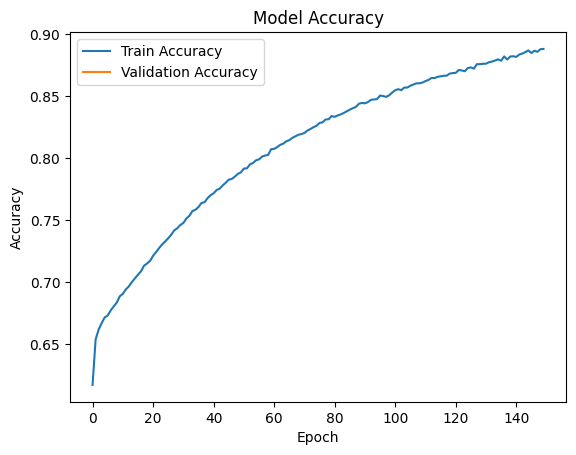

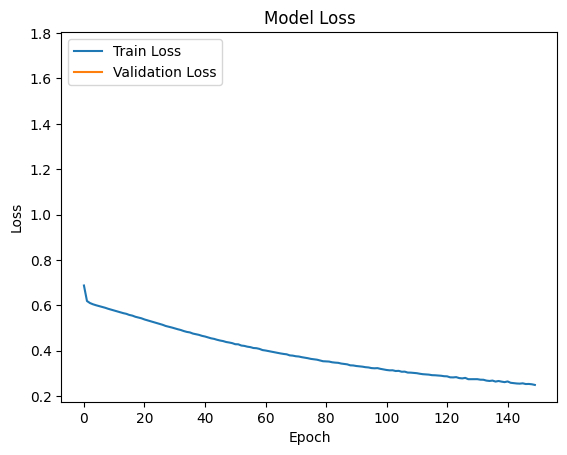

In [ ]:
padded_val_acc_history = [None] * epochs
padded_val_loss_history = [None] * epochs
for i, epoch in enumerate(range(validate_every_n_epochs - 1, epochs, validate_every_n_epochs)):
    padded_val_acc_history[epoch] = val_acc_history[i]
    padded_val_loss_history[epoch] = val_loss_history[i]

# Plot training & validation accuracy values
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(padded_val_acc_history, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(train_loss_history, label='Train Loss')
plt.plot(padded_val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_pred = combined_model.predict([test_images, test_landmarks])
test_pred_classes = np.round(test_pred)

# Get the true classes of the test set
test_true_classes = test_labels


 11/341 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

W0000 00:00:1717923354.663083     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/341 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step


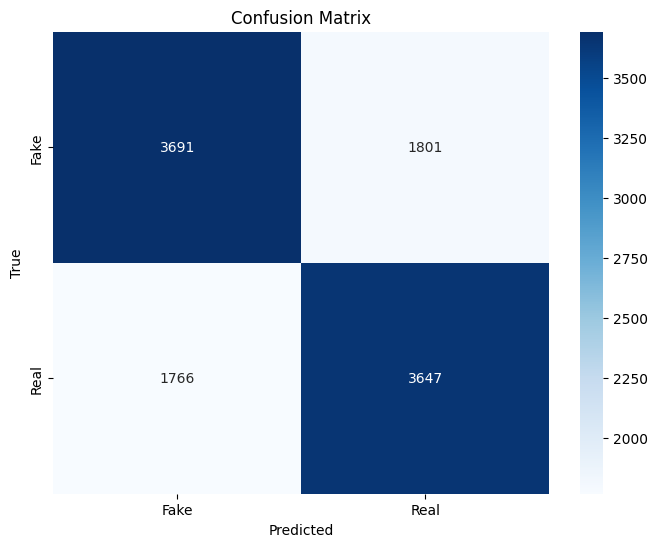

  7/341 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7919 - loss: 0.8523

W0000 00:00:1717923398.743751     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/341 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6610 - loss: 2.1533
Test Accuracy: 67.29%
Classification Report:
               precision    recall  f1-score   support

     Class 0     0.6764    0.6721    0.6742      5492
     Class 1     0.6694    0.6737    0.6716      5413

    accuracy                         0.6729     10905
   macro avg     0.6729    0.6729    0.6729     10905
weighted avg     0.6729    0.6729    0.6729     10905



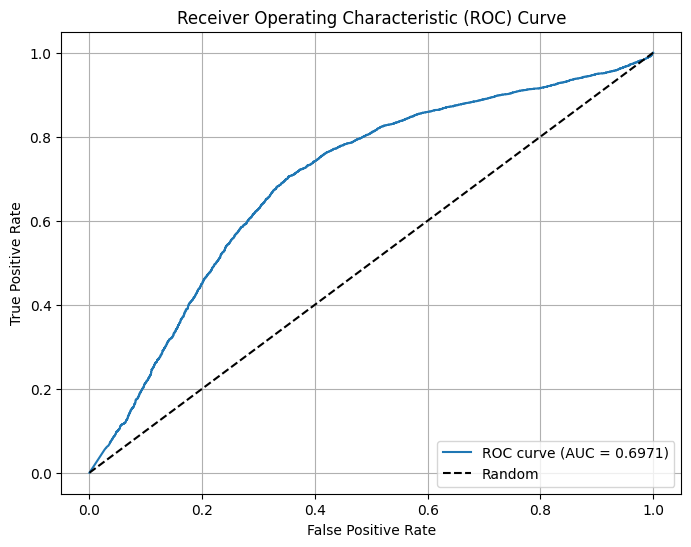

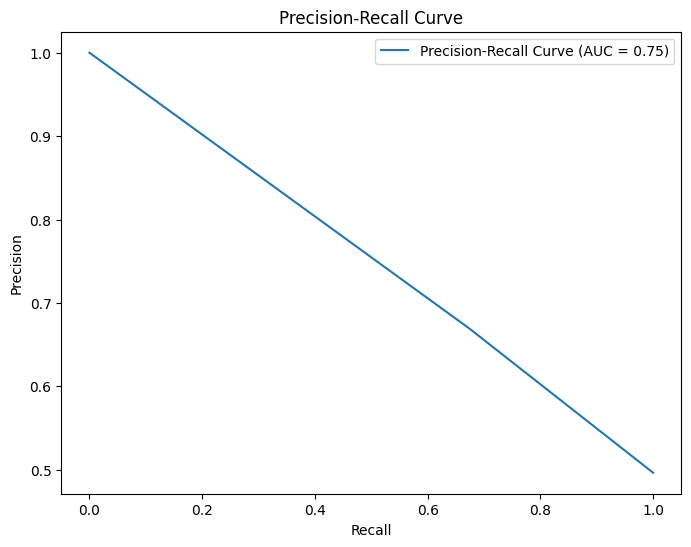

Sensitivity (True Positive Rate): 0.6737
Specificity (True Negative Rate): 0.6721
F1 Score: 0.6716
Error Rate: 0.3271
G-mean: 0.6729
F-measure: 0.6729


In [ ]:
# Plot confusion matrix as a heatmap
cm = confusion_matrix(test_true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

evaluation = combined_model.evaluate([test_images, test_landmarks], test_true_classes)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

# Classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=["Class 0", "Class 1"], labels=[0, 1], digits=4)
print("Classification Report:\n", report)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_true_classes, test_pred)
roc_auc = roc_auc_score(test_true_classes, test_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(test_true_classes, test_pred_classes)
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(test_true_classes, test_pred_classes).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')

# Calculate F1 score, error rate, G-mean, and F-measure
f1 = f1_score(test_true_classes, test_pred_classes)
accuracy = accuracy_score(test_true_classes, test_pred_classes)
error_rate = 1 - accuracy
g_mean = (sensitivity * specificity) ** 0.5
f_measure = 2 * ((sensitivity * specificity) / (sensitivity + specificity))
print(f'F1 Score: {f1:.4f}')
print(f'Error Rate: {error_rate:.4f}')
print(f'G-mean: {g_mean:.4f}')
print(f'F-measure: {f_measure:.4f}')


In [ ]:
import numpy as np
import pandas as pd
from keras.applications import ResNet50
import os
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, f1_score, accuracy_score
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Reshape, concatenate, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
import mediapipe as mp
import requests
from PIL import Image
from io import BytesIO

In [ ]:
# Save the model
model_save_path = "deepfake_detection_model.h5"
combined_model.save(model_save_path)
print("Model saved at:", model_save_path)

Model saved at: deepfake_detection_model.h5
